In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf

import sys
sys.path.append('/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/')

from enum import Enum

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

import tensorflow_probability as tfp
from scipy.stats import beta, truncnorm


# Local imports from model.py, data.py
from model import CovidModel, LogPoissonProb, get_logging_callbacks, Comp, Vax
from model_config import ModelConfig
from data import read_data, create_warmup
#from plots import make_all_plots

import scipy

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20}) # set plot font sizes

2022-03-07 17:52:42.176241: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-07 17:52:42.176506: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
transition_window =10

warmup_start = '20210421'
warmup_end = '20210430'
train_start = '20210501'
train_end = '20210731'
test_start = '20210801'
test_end = '20210831'

state = 'Massachusetts'
state_abbrev = 'MA'

data_dir = '../data'
covid_estim_date = '20210901'
hhs_date = '20210903'
owid_date = '20210903'

# Learning rate
learning_rate = 0.01

In [3]:
df = read_data(data_dir=data_dir,
               covid_estim_date=covid_estim_date,
               hhs_date=hhs_date,
               owid_date=owid_date,
               state=state, state_abbrev=state_abbrev)
vax_statuses = [Vax.yes, Vax.no]
x_train = tf.cast(df.loc[train_start:train_end,'Rt'].values, dtype=tf.float32)
x_test = tf.cast(df.loc[train_start:test_end,'Rt'].values, dtype=tf.float32)


y_train = {}
y_train['G_in'] = tf.cast(df.loc[train_start:train_end,'general_ward_in'], dtype=tf.float32)
y_train['G_count'] = tf.cast(df.loc[train_start:train_end,'general_ward_count'], dtype=tf.float32)
y_train['I_count'] = tf.cast(df.loc[train_start:train_end,'icu_count'], dtype=tf.float32)
y_train['D_in'] = tf.cast(df.loc[train_start:train_end,'deaths_covid'], dtype=tf.float32) + 1

y_test = {}
y_test['G_in'] = tf.cast(df.loc[train_start:test_end,'general_ward_in'], dtype=tf.float32)
y_test['G_count'] = tf.cast(df.loc[train_start:test_end,'general_ward_count'], dtype=tf.float32)
y_test['I_count'] = tf.cast(df.loc[train_start:test_end,'icu_count'], dtype=tf.float32)
y_test['D_in'] = tf.cast(df.loc[train_start:test_end,'deaths_covid'], dtype=tf.float32)

2022-03-07 17:52:55.199686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-07 17:52:55.200127: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-07 17:52:55.200214: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-07 17:52:55.200286: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-07 17:52:55.200339: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [4]:
config = ModelConfig.from_json('/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/after_training.json')

In [5]:
model = CovidModel([Vax.no, Vax.yes], [Comp.A, Comp.M, Comp.G, Comp.GR, Comp.I, Comp.IR, Comp.D],
                 transition_window,
                config, posterior_samples=1000, debug_disable_theta=False,
                  fix_variance=True)

pre_training_preds=model.call(x_train)

In [29]:
loss = LogPoissonProb() 
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,#beta_1=0.1, beta_2=0.1
)
#loss((y_train['G_count'], y_train['G_in'], y_train['I_count'], y_train['D_in']), pre_training_preds)

In [30]:
logging_callbacks = get_logging_callbacks('/mnt/c/Users/kheut/logs/covid/scale_var_properly_reduce_learning/')

2022-03-03 08:54:02.969267: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-03 08:54:02.969632: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-03 08:54:02.971449: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2022-03-03 08:54:02.971549: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-03 08:54:02.971908: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.


In [34]:
model.compile(loss=loss, optimizer=optimizer, run_eagerly=True)
model.fit(x=np.asarray([x_train]), y=np.asarray([(y_train['G_count'], y_train['G_in'], y_train['I_count'], y_train['D_in'])]),
         epochs=2000, batch_size=0,
        callbacks=logging_callbacks)

Epoch 1/2000
G count: -10.463743209838867
G in: -3.9611995220184326
I count: -6.548534393310547
D in: -2.470189332962036
1/1 [==============================] - 81s 81s/step - loss: 49.8685
Epoch 2/2000


2022-03-03 13:55:17.417109: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-03 13:55:17.417568: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-03 13:55:17.419289: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


G count: -10.667339324951172
G in: -3.934809923171997
I count: -6.683983325958252
D in: -2.476841926574707
1/1 [==============================] - ETA: 0s - loss: 50.0854

2022-03-03 13:56:23.759458: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-03-03 13:56:24.585196: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2022-03-03 13:56:30.154212: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-03-03 13:56:47.350807: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-03 13:57:06.470120: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /mnt/c/Users/kheut/logs/covid/scale_var_properly_reduce_learning/train/plugins/profile/2022_03_03_13_56_47

2022-03-03 13:57:07.692082: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /mnt/c/Users/kheut/logs/covid/scale_var_properly_reduce_lea

1/1 [==============================] - 118s 118s/step - loss: 50.0854
Epoch 3/2000
G count: -10.63306999206543
G in: -3.993086814880371
I count: -6.359706878662109
D in: -2.481827735900879
1/1 [==============================] - 48s 48s/step - loss: 49.7928
Epoch 4/2000
G count: -10.650849342346191
G in: -3.9562063217163086
I count: -6.6217451095581055
D in: -2.4841957092285156
1/1 [==============================] - 47s 47s/step - loss: 50.1761
Epoch 5/2000
G count: -10.021010398864746
G in: -3.9444291591644287
I count: -6.601232051849365
D in: -2.4774138927459717
1/1 [==============================] - 47s 47s/step - loss: 49.3393
Epoch 6/2000
G count: -10.046658515930176
G in: -3.9682650566101074
I count: -6.558358669281006
D in: -2.4694995880126953
1/1 [==============================] - 50s 50s/step - loss: 49.4875
Epoch 7/2000
G count: -9.957961082458496
G in: -3.98091983795166
I count: -6.607729911804199
D in: -2.474851131439209
1/1 [==============================] - 51s 51s/step - 

1/1 [==============================] - 50s 50s/step - loss: 49.8199
Epoch 89/2000
G count: -10.49604606628418
G in: -3.975191831588745
I count: -6.39076042175293
D in: -2.453721523284912
1/1 [==============================] - 49s 49s/step - loss: 49.5386
Epoch 90/2000
G count: -10.205299377441406
G in: -3.9996962547302246
I count: -6.3708815574646
D in: -2.4564690589904785
1/1 [==============================] - 49s 49s/step - loss: 49.5404
Epoch 91/2000
G count: -10.483636856079102
G in: -3.9647350311279297
I count: -6.5626020431518555
D in: -2.4645090103149414
1/1 [==============================] - 49s 49s/step - loss: 50.1366
Epoch 92/2000
G count: -10.246504783630371
G in: -4.010390758514404
I count: -6.815305709838867
D in: -2.467186689376831
1/1 [==============================] - 49s 49s/step - loss: 49.9857
Epoch 93/2000
G count: -10.325614929199219
G in: -3.949312925338745
I count: -6.749955654144287
D in: -2.4680819511413574
1/1 [==============================] - 48s 48s/step -

1/1 [==============================] - 48s 48s/step - loss: 49.7042
Epoch 175/2000
G count: -10.32152271270752
G in: -3.9575629234313965
I count: -6.408393383026123
D in: -2.4842395782470703
1/1 [==============================] - 48s 48s/step - loss: 49.6320
Epoch 176/2000
G count: -10.174371719360352
G in: -3.966966390609741
I count: -6.492870807647705
D in: -2.4944379329681396
1/1 [==============================] - 50s 50s/step - loss: 49.5609
Epoch 177/2000
G count: -10.333395957946777
G in: -3.9805753231048584
I count: -6.278576374053955
D in: -2.4963185787200928
1/1 [==============================] - 49s 49s/step - loss: 49.6317
Epoch 178/2000
G count: -10.261709213256836
G in: -3.9515514373779297
I count: -6.4214935302734375
D in: -2.4849350452423096
1/1 [==============================] - 49s 49s/step - loss: 49.5854
Epoch 179/2000
G count: -10.219754219055176
G in: -3.9622249603271484
I count: -6.695553302764893
D in: -2.485706329345703
1/1 [==============================] - 50s

1/1 [==============================] - 50s 50s/step - loss: 49.4075
Epoch 218/2000
G count: -10.153826713562012
G in: -3.9733691215515137
I count: -6.506881237030029
D in: -2.481454372406006
1/1 [==============================] - 49s 49s/step - loss: 49.8531
Epoch 219/2000
G count: -10.431905746459961
G in: -3.946986436843872
I count: -6.501371383666992
D in: -2.4755234718322754
1/1 [==============================] - 51s 51s/step - loss: 49.9182
Epoch 220/2000
G count: -10.383857727050781
G in: -3.969247817993164
I count: -6.4311370849609375
D in: -2.475480556488037
1/1 [==============================] - 48s 48s/step - loss: 49.7476
Epoch 221/2000
G count: -10.261305809020996
G in: -3.9536325931549072
I count: -6.902755260467529
D in: -2.4734342098236084
1/1 [==============================] - 47s 47s/step - loss: 49.9806
Epoch 222/2000
G count: -10.231280326843262
G in: -3.9327847957611084
I count: -6.6829681396484375
D in: -2.474867582321167
1/1 [==============================] - 47s 

1/1 [==============================] - 46s 46s/step - loss: 49.6294
Epoch 261/2000
G count: -10.421220779418945
G in: -3.933443069458008
I count: -6.233792304992676
D in: -2.469017505645752
1/1 [==============================] - 46s 46s/step - loss: 49.4860
Epoch 262/2000
G count: -10.386931419372559
G in: -3.986332654953003
I count: -6.4831085205078125
D in: -2.4801316261291504
1/1 [==============================] - 46s 46s/step - loss: 49.9099
Epoch 263/2000
G count: -9.940735816955566
G in: -3.9603023529052734
I count: -6.458080768585205
D in: -2.4847118854522705
1/1 [==============================] - 47s 47s/step - loss: 49.2319
Epoch 264/2000
G count: -10.182716369628906
G in: -3.9729371070861816
I count: -6.626230716705322
D in: -2.4832465648651123
1/1 [==============================] - 46s 46s/step - loss: 50.0756
Epoch 265/2000
G count: -10.159806251525879
G in: -3.9575467109680176
I count: -6.68146276473999
D in: -2.4794809818267822
1/1 [==============================] - 46s 4

1/1 [==============================] - 47s 47s/step - loss: 50.2471
Epoch 304/2000
G count: -10.107806205749512
G in: -3.987957239151001
I count: -6.48049259185791
D in: -2.473243474960327
1/1 [==============================] - 46s 46s/step - loss: 49.6602
Epoch 305/2000
G count: -10.367634773254395
G in: -3.978705644607544
I count: -6.770389556884766
D in: -2.488192558288574
1/1 [==============================] - 46s 46s/step - loss: 50.2507
Epoch 306/2000
G count: -9.939952850341797
G in: -3.9472129344940186
I count: -6.4127421379089355
D in: -2.4831197261810303
1/1 [==============================] - 46s 46s/step - loss: 49.2565
Epoch 307/2000
G count: -10.180455207824707
G in: -3.9669995307922363
I count: -6.68964147567749
D in: -2.4759786128997803
1/1 [==============================] - 46s 46s/step - loss: 49.5180
Epoch 308/2000
G count: -10.458434104919434
G in: -3.9751834869384766
I count: -6.627821445465088
D in: -2.4844839572906494
1/1 [==============================] - 46s 46s

1/1 [==============================] - 60s 60s/step - loss: 49.8069
Epoch 347/2000
G count: -10.190520286560059
G in: -4.028264999389648
I count: -6.68414306640625
D in: -2.4685778617858887
1/1 [==============================] - 58s 58s/step - loss: 49.7348
Epoch 348/2000
G count: -10.382804870605469
G in: -4.0225934982299805
I count: -6.735264778137207
D in: -2.4648172855377197
1/1 [==============================] - 63s 63s/step - loss: 50.2889
Epoch 349/2000
G count: -10.299615859985352
G in: -3.9937896728515625
I count: -6.506819248199463
D in: -2.4617316722869873
1/1 [==============================] - 64s 64s/step - loss: 49.7573
Epoch 350/2000
G count: -10.235766410827637
G in: -3.9722702503204346
I count: -6.585838794708252
D in: -2.468905210494995
1/1 [==============================] - 60s 60s/step - loss: 49.9897
Epoch 351/2000
G count: -10.201086044311523
G in: -3.9887359142303467
I count: -6.230326175689697
D in: -2.466045618057251
1/1 [==============================] - 55s 5

1/1 [==============================] - 49s 49s/step - loss: 49.5329
Epoch 390/2000
G count: -10.284252166748047
G in: -3.9492080211639404
I count: -6.762254238128662
D in: -2.488459825515747
1/1 [==============================] - 50s 50s/step - loss: 49.9747
Epoch 391/2000
G count: -10.095863342285156
G in: -3.967027187347412
I count: -6.485680103302002
D in: -2.492772102355957
1/1 [==============================] - 50s 50s/step - loss: 49.4602
Epoch 392/2000
G count: -10.367528915405273
G in: -3.9825518131256104
I count: -6.448577404022217
D in: -2.4766461849212646
1/1 [==============================] - 48s 48s/step - loss: 49.7338
Epoch 393/2000
G count: -10.133997917175293
G in: -3.9470462799072266
I count: -6.420999050140381
D in: -2.475494146347046
1/1 [==============================] - 48s 48s/step - loss: 49.3822
Epoch 394/2000
G count: -10.309100151062012
G in: -3.9663755893707275
I count: -6.374746799468994
D in: -2.4726674556732178
1/1 [==============================] - 46s 4

1/1 [==============================] - 52s 52s/step - loss: 49.9600
Epoch 433/2000
G count: -9.962533950805664
G in: -3.9736108779907227
I count: -7.010997772216797
D in: -2.460571050643921
1/1 [==============================] - 52s 52s/step - loss: 49.8680
Epoch 434/2000
G count: -10.241600036621094
G in: -3.9849393367767334
I count: -6.857070446014404
D in: -2.4613447189331055
1/1 [==============================] - 49s 49s/step - loss: 50.0727
Epoch 435/2000
G count: -10.150171279907227
G in: -3.97731876373291
I count: -6.69545841217041
D in: -2.458555221557617
1/1 [==============================] - 47s 47s/step - loss: 49.8610
Epoch 436/2000
G count: -10.354209899902344
G in: -3.990920305252075
I count: -6.637239456176758
D in: -2.4617912769317627
1/1 [==============================] - 48s 48s/step - loss: 49.6492
Epoch 437/2000
G count: -10.576986312866211
G in: -3.9903409481048584
I count: -6.832104206085205
D in: -2.4576706886291504
1/1 [==============================] - 48s 48s/

1/1 [==============================] - 45s 45s/step - loss: 50.0452
Epoch 476/2000
G count: -10.330135345458984
G in: -4.009359836578369
I count: -6.446486949920654
D in: -2.4752848148345947
1/1 [==============================] - 45s 45s/step - loss: 49.8437
Epoch 477/2000
G count: -10.367291450500488
G in: -3.954193115234375
I count: -6.496613025665283
D in: -2.473201036453247
1/1 [==============================] - 45s 45s/step - loss: 49.7952
Epoch 478/2000
G count: -10.464588165283203
G in: -3.967437744140625
I count: -6.4125566482543945
D in: -2.480409622192383
1/1 [==============================] - 45s 45s/step - loss: 49.8630
Epoch 479/2000
G count: -10.29865837097168
G in: -3.9947562217712402
I count: -6.445531368255615
D in: -2.479012966156006
1/1 [==============================] - 45s 45s/step - loss: 50.0187
Epoch 480/2000
G count: -10.234190940856934
G in: -3.9797048568725586
I count: -6.447354316711426
D in: -2.4722766876220703
1/1 [==============================] - 46s 46s

1/1 [==============================] - 45s 45s/step - loss: 49.6372
Epoch 519/2000
G count: -10.386312484741211
G in: -3.969404697418213
I count: -6.617257118225098
D in: -2.459494113922119
1/1 [==============================] - 45s 45s/step - loss: 49.8809
Epoch 520/2000
G count: -10.141223907470703
G in: -3.98896861076355
I count: -6.59784460067749
D in: -2.4583935737609863
1/1 [==============================] - 46s 46s/step - loss: 49.7288
Epoch 521/2000
G count: -10.233084678649902
G in: -3.9545719623565674
I count: -6.7273478507995605
D in: -2.453057050704956
1/1 [==============================] - 45s 45s/step - loss: 49.8395
Epoch 522/2000
G count: -10.15311050415039
G in: -3.967893123626709
I count: -6.535775184631348
D in: -2.4584734439849854
1/1 [==============================] - 45s 45s/step - loss: 49.6471
Epoch 523/2000
G count: -10.289435386657715
G in: -3.979343891143799
I count: -6.5687150955200195
D in: -2.458179235458374
1/1 [==============================] - 45s 45s/s

1/1 [==============================] - 45s 45s/step - loss: 49.8304
Epoch 562/2000
G count: -10.261797904968262
G in: -3.990266799926758
I count: -6.447177886962891
D in: -2.4784061908721924
1/1 [==============================] - 45s 45s/step - loss: 49.6961
Epoch 563/2000
G count: -10.32972526550293
G in: -3.9945037364959717
I count: -6.824488639831543
D in: -2.468196153640747
1/1 [==============================] - 45s 45s/step - loss: 50.3844
Epoch 564/2000
G count: -9.954521179199219
G in: -3.960073709487915
I count: -6.573834419250488
D in: -2.466475009918213
1/1 [==============================] - 45s 45s/step - loss: 49.3418
Epoch 565/2000
G count: -10.283227920532227
G in: -3.947089433670044
I count: -6.458024501800537
D in: -2.4627246856689453
1/1 [==============================] - 45s 45s/step - loss: 49.6103
Epoch 566/2000
G count: -10.388543128967285
G in: -3.9863693714141846
I count: -6.510452747344971
D in: -2.4722678661346436
1/1 [==============================] - 45s 45s/

1/1 [==============================] - 49s 49s/step - loss: 49.8211
Epoch 605/2000
G count: -10.106156349182129
G in: -3.97436785697937
I count: -6.527021408081055
D in: -2.4858734607696533
1/1 [==============================] - 50s 50s/step - loss: 49.3350
Epoch 606/2000
G count: -10.341948509216309
G in: -3.9595303535461426
I count: -6.675598621368408
D in: -2.4705748558044434
1/1 [==============================] - 47s 47s/step - loss: 49.9334
Epoch 607/2000
G count: -10.274693489074707
G in: -3.945850133895874
I count: -6.547789096832275
D in: -2.4629290103912354
1/1 [==============================] - 47s 47s/step - loss: 49.7188
Epoch 608/2000
G count: -10.095187187194824
G in: -3.9469070434570312
I count: -6.50636100769043
D in: -2.4716131687164307
1/1 [==============================] - 46s 46s/step - loss: 49.5854
Epoch 609/2000


KeyboardInterrupt: 

In [ ]:
model.variables

Text(0.5, 1.0, 'ICU Count')

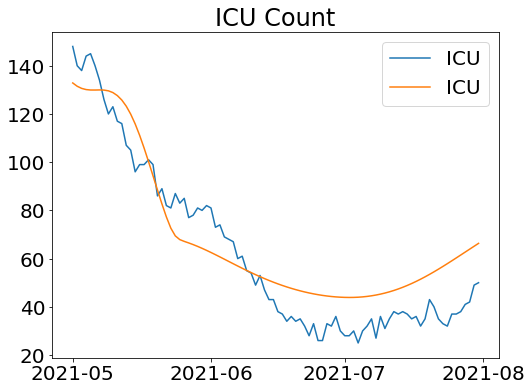

In [8]:
plt.figure(figsize=(8, 6))
preds=tf.reduce_mean(model.call(x_train), axis=-1)
plt.plot(df.loc[train_start:train_end].index.values, y_train['I_count'], label='ICU')
plt.plot(df.loc[train_start:train_end].index.values, preds[0][2], label='ICU')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('ICU Count')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Gen Count')

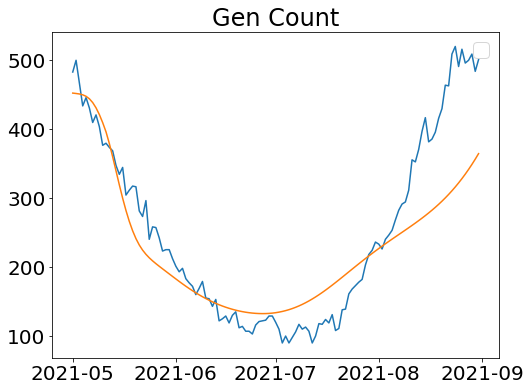

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(df.loc[train_start:test_end].index.values, y_test['G_count'], )
plt.plot(df.loc[train_start:test_end].index.values, preds[0][0])
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Gen Count')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Gen Influx')

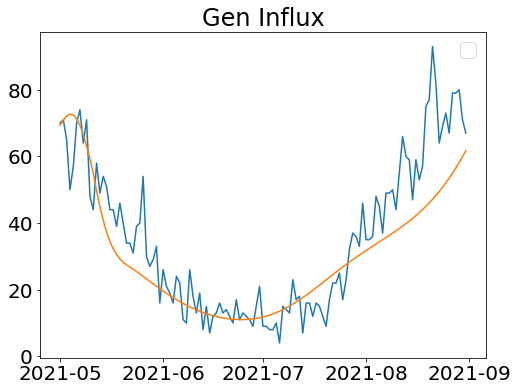

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(df.loc[train_start:test_end].index.values, y_test['G_in'], )
plt.plot(df.loc[train_start:test_end].index.values, preds[0][1])
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Gen Influx')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Death Influx')

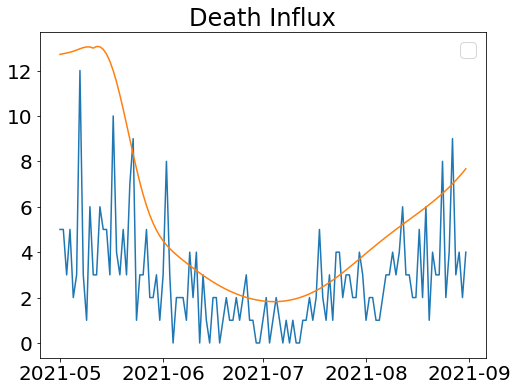

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(df.loc[train_start:test_end].index.values, y_test['D_in'], )
plt.plot(df.loc[train_start:test_end].index.values, preds[0][3])
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Death Influx')

In [ ]:
model._sample_and_reparameterize()

In [ ]:
model.rho_M_params

In [ ]:
model.rho_M_samples_constrained

In [ ]:
!pwd

In [40]:
new_config = model.config.update_from_model(model)

In [41]:
new_config.to_json("/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/after_training.json")

In [ ]:
y_train

In [ ]:
model.init_count_G_params

In [ ]:
model.config.init_count_I.value

In [ ]:
new_config = model.config.update_from_model(model)

In [ ]:
new_config.to_json("/mnt/c/Users/kheut/Downloads/fix_after_600.json")

In [ ]:
model.variables

In [ ]:
model.init_count_G_params

In [ ]:
model.variables

In [ ]:
model.init_count_G_samples_constrained[0].numpy().min(), model.init_count_G_samples_constrained[0].numpy().max()

In [ ]:
tfp.bijectors.Softplus.inverse(17/100)

In [ ]:
new_config.init_count_I.value

In [ ]:
model.config.init_count_G.value[1]['scale']

In [ ]:
model.init_count_G_params

In [ ]:
tf.random.normal((1000, ))

In [33]:
model.warmup_I_samples_constrained

defaultdict(int,
            {0: [<tf.Tensor: shape=(1000,), dtype=float32, numpy=
              array([14.536421 , 12.357904 , 13.719024 , 13.699513 , 13.1986065,
                     13.37474  , 13.218949 , 13.539405 , 13.359721 , 13.426119 ,
                     14.618379 , 12.428498 , 13.312584 , 13.29663  , 11.711953 ,
                     13.569498 , 14.467316 , 12.754033 , 13.734563 , 12.793829 ,
                     13.268837 , 14.591658 , 13.769635 , 12.820991 , 13.641492 ,
                     13.903706 , 13.149222 , 13.154808 , 13.845081 , 12.944219 ,
                     14.777203 , 12.514761 , 13.312328 , 12.374355 , 12.687342 ,
                     13.459426 , 14.670603 , 14.325047 , 13.2248   , 13.760859 ,
                     13.780361 , 13.208374 , 13.961972 , 14.074482 , 13.25656  ,
                     14.224248 , 14.2782135, 14.779804 , 12.891086 , 12.619053 ,
                     14.075261 , 13.429065 , 13.600643 , 13.015562 , 12.806471 ,
                     14.72